In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.utils.checkpoint

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt


from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report


import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import models
from torchvision.io import read_image
from torchvision.io import write_png
from torchvision.io import ImageReadMode
import torchvision.transforms.functional as transform_fun
from torchvision.datasets import ImageFolder
# from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import img_to_array
from torchvision.utils import save_image
import glob
import data_loader as DL
import os, shutil
import cv2
import torchvision
import matplotlib.pyplot as plt
import json

In [2]:
device = 'cuda' if torch.cuda.is_available() else  'cpu'
device

'cuda'

In [18]:
# for if gpu mem is full
import torch

from numba import cuda

def free_gpu_cache():


    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)


free_gpu_cache()  

In [3]:
masked_path_test = 'raw/test/Masked/*.png'
Nomask_path_test ='raw/test/Nomask/*.png'


masked_path_train = 'raw/train/Masked/*'
Nomask_path_train ='raw/train/Nomask/*'

In [4]:
stand_train_masked = 'Train_std/masked' 
stand_train_Nomask = 'Train_std/Nomask' 

In [5]:
train_path = 'Train_std'
test_path = 'test2'


## class distribution

In [6]:
# get the paths into a list
list_mask_paths = glob.glob(masked_path_train)
list_Nomask_paths = glob.glob(Nomask_path_train)

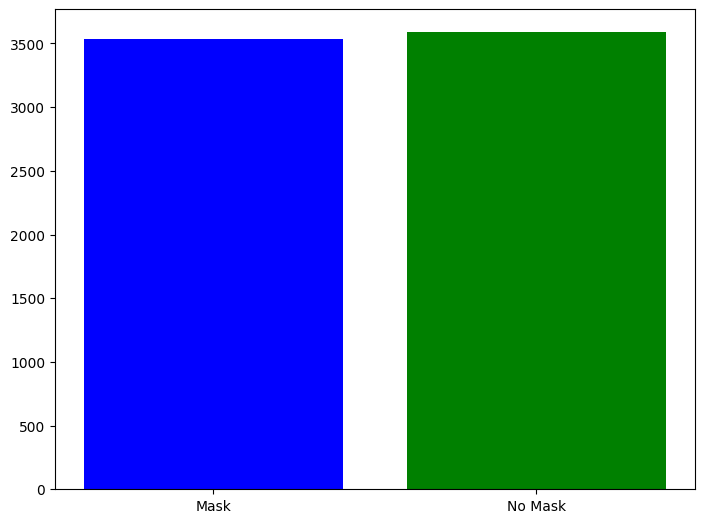

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

list_names = ['Mask','No Mask']
data = [len(list_mask_paths) ,len(list_Nomask_paths)]

ax.bar(list_names,data,color=['blue', 'green'])

plt.show()

In [8]:
len(list_mask_paths) , len(list_Nomask_paths)

(3539, 3589)

we can see that the dataset balanced we don't need to balance it , but we need to resize it and to augment it

## data augment / resizing

In [27]:
def move_files(path,Npath):
    if not os.path.exists(Npath):
        os.makedirs(Npath)
    
    for file in path:
        try:
            os.rename(file, Npath+'/'+file[22:])
        except:
            pass

In [104]:
def resize(path,Npath,size):
    aug = torch.nn.Sequential(
        transforms.Resize((size,size)),
        transforms.ColorJitter(brightness=0.5),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomInvert(p=0.1),
        transforms.RandomEqualize(p=0.1),
        transforms.RandomPosterize(p=0.1,bits=8)
    )
    i = 1
    transform = transforms.Compose([transforms.ToPILImage()])
    transform2 = transforms.Compose([transforms.ToTensor()])

    for file in path:
        img = read_image(path=file, mode=ImageReadMode.RGB)
        img = transform(img)
        X = aug(img)
        save_image(transform2(X).to(torch.float),fp=Npath+'/'+'__'+str(i)+'__.png')
        i+=1

In [108]:
resize(glob.glob(masked_path_train),stand_train_masked,224)
resize(glob.glob(Nomask_path_train),stand_train_Nomask,224)
# resize(glob.glob('ready/ready/*.png'),stand_train_Nomask,224)

## Data loading

In [6]:
transform = transforms.Compose([

    transforms.ToTensor(),

])

train_data = ImageFolder(root=train_path, transform= transform)

test_data = ImageFolder(root=test_path, transform= transform)

In [7]:
train_data_load2 = DL.data_loader(train_data, 100,True)
test_data_load2 = DL.data_loader(test_data,100,False)


## model loading

this is a pretrained resnet50 we would only need to tune it but first let's change the output of the classifer layer to fit our case

In [8]:
import warnings
warnings.filterwarnings('ignore')
torch.cuda.manual_seed(42)
torch.manual_seed(42)
model = models.resnet50(pretrained=True).to(device)
print(model)
for para in model.parameters():
    para.requires_grad = False
# frezing every layer apart from the first and last
num_feats = model.fc.in_features
model.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(in_features=num_feats, out_features=2, bias=True) # we only have three classes

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
# let's check the last layer
model.to(device)
model.fc

Linear(in_features=2048, out_features=2, bias=True)

## Loss function and optim function

In [10]:
optim = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()
# nn.BCEWithLogitsLoss()
step = torch.optim.lr_scheduler.StepLR(optim,step_size=10,gamma=0.1)

## train test functions

In [11]:
def test_with_ac(test_labels,model):
    y_proba,y_pred,y_true = test_model(test_labels,model)
    cnf_matrix=confusion_matrix(y_true,y_pred)
    recall = cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0])
    ac = (cnf_matrix[1,1,] + cnf_matrix[0,0]) / (cnf_matrix[1,1,] + cnf_matrix[0,0] + cnf_matrix[0,1] + cnf_matrix[1,0])
    pc = cnf_matrix[1,1,]/(cnf_matrix[1,1,]+cnf_matrix[0,1])
    false_pos_rate = cnf_matrix[0,1] / (cnf_matrix[0,1] + cnf_matrix[0,0])
    f1_score = (2*recall * pc) /( recall + pc)
    

    print(classification_report(y_true, y_pred, digits=5))
    return recall,pc,ac,f1_score,false_pos_rate

In [12]:
def Train_test_on_model(epochs,train_data_load,test_data_load,model):
    train_loss = []
    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n-------")
        temp =0
        
        for batch, (X, y) in enumerate(train_data_load):
                model.train(True)
                X1,y1 = X.to(device),y.to(device)
                y_pred = model(X1).squeeze()
                loss = loss_fn(y_pred, y1)
                temp += loss
                optim.zero_grad()
                loss.backward()
                optim.step()
        temp = 10   
        temp /= len(train_data_load)
        recall,pc,ac,f1_score,false_pos_rate = test_with_ac(test_data_load,model)
        print(f"\nTrain loss: {temp:.5f} | Test f1: {f1_score:.4f}, Test acc: {ac:.4f}, Test PC {pc:.4f}\n")

In [13]:
def test_model(test_data_load,model):
    y_pred = []
    y_true = []
    y_proba = []
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_data_load):
                X1,y1 = X.to(device),y.to(device)
#                 torch.softmax(y_pred_prob,dim=1).argmax(dim=1)
                y_pred_prob = model(X1).squeeze()
                temp = torch.softmax(y_pred_prob,dim=1).argmax(dim=1)
                y_pred.extend(temp.to('cpu'))
                y_true.extend(y1.to('cpu'))
                y_proba.extend(y_pred_prob)
    return y_proba,y_pred,y_true

In [14]:
def model_val(labels_test,pred, pred_proba):
    cnf_matrix=confusion_matrix(labels_test,pred)
#     print("AUC",roc_auc_score(labels_test, pred_proba))
    print("the recall for this model is :",cnf_matrix[1,1]/(cnf_matrix[1,1]+cnf_matrix[1,0]))
    fig= plt.figure(figsize=(6,3))# to plot the graph
    print(cnf_matrix)
    print("TP",cnf_matrix[1,1,]) # no of fraud transaction which are predicted fraud
    print("TN",cnf_matrix[0,0]) # no. of normal transaction which are predited normal
    print("FP",cnf_matrix[0,1]) # no of normal transaction which are predicted fraud
    print("FN",cnf_matrix[1,0]) # no of fraud Transaction which are predicted normal
    sns.heatmap(cnf_matrix,cmap="coolwarm_r",annot=True,linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(labels_test,pred, digits=5))
    print(classification_report_imbalanced(labels_test, pred, digits=5))

In [15]:
# Train_on_model(100,train_data_load) #10 + 5 +3 +3 +3+3 +3 +5 // 19_5 + 3 + 3
# Train_on_model(1,val_data_load) 10 epoches
Train_test_on_model(5,train_data_load2,test_data_load2,model) # 6 + 3 + 3 + 3

Epoch: 0
-------
              precision    recall  f1-score   support

           0    0.79686   0.84774   0.82151      1018
           1    0.82797   0.77226   0.79914       966

    accuracy                        0.81099      1984
   macro avg    0.81241   0.81000   0.81033      1984
weighted avg    0.81201   0.81099   0.81062      1984


Train loss: 0.13889 | Test f1: 0.7991, Test acc: 0.8110, Test PC 0.8280

Epoch: 1
-------
              precision    recall  f1-score   support

           0    0.70575   0.92829   0.80187      1018
           1    0.88682   0.59213   0.71012       966

    accuracy                        0.76462      1984
   macro avg    0.79629   0.76021   0.75599      1984
weighted avg    0.79391   0.76462   0.75719      1984


Train loss: 0.13889 | Test f1: 0.7101, Test acc: 0.7646, Test PC 0.8868

Epoch: 2
-------
              precision    recall  f1-score   support

           0    0.93144   0.54715   0.68936      1018
           1    0.66739   0.95756   0.

In [16]:
for para in model.parameters(): # unfrezing the rest and training for 4 epoch
    para.requires_grad = True

In [18]:
optim = torch.optim.Adam(model.parameters(),lr=0.0001)

In [19]:
Train_test_on_model(4,train_data_load2,test_data_load2,model) # 4

Epoch: 0
-------
              precision    recall  f1-score   support

           0    0.96526   0.90079   0.93191      1018
           1    0.90232   0.96584   0.93300       966

    accuracy                        0.93246      1984
   macro avg    0.93379   0.93331   0.93246      1984
weighted avg    0.93462   0.93246   0.93244      1984


Train loss: 0.13889 | Test f1: 0.9330, Test acc: 0.9325, Test PC 0.9023

Epoch: 1
-------
              precision    recall  f1-score   support

           0    0.96812   0.89489   0.93007      1018
           1    0.89741   0.96894   0.93181       966

    accuracy                        0.93095      1984
   macro avg    0.93277   0.93192   0.93094      1984
weighted avg    0.93369   0.93095   0.93091      1984


Train loss: 0.13889 | Test f1: 0.9318, Test acc: 0.9309, Test PC 0.8974

Epoch: 2
-------
              precision    recall  f1-score   support

           0    0.97884   0.90864   0.94244      1018
           1    0.91049   0.97930   0.

In [103]:
Train_test_on_model(3,train_data_load2,test_data_load2,model) #

Epoch: 0
-------
              precision    recall  f1-score   support

           0    0.96000   0.94303   0.95144      1018
           1    0.94106   0.95859   0.94974       966

    accuracy                        0.95060      1984
   macro avg    0.95053   0.95081   0.95059      1984
weighted avg    0.95078   0.95060   0.95061      1984


Train loss: 0.17544 | Test f1: 0.9497, Test acc: 0.9506, Test PC 0.9411

Epoch: 1
-------
              precision    recall  f1-score   support

           0    0.97707   0.87917   0.92554      1018
           1    0.88483   0.97826   0.92920       966

    accuracy                        0.92742      1984
   macro avg    0.93095   0.92872   0.92737      1984
weighted avg    0.93216   0.92742   0.92733      1984


Train loss: 0.17544 | Test f1: 0.9292, Test acc: 0.9274, Test PC 0.8848

Epoch: 2
-------
              precision    recall  f1-score   support

           0    0.96657   0.93713   0.95162      1018
           1    0.93581   0.96584   0.

In [20]:
PATH = 'model6-5firsttwo_4all_'




In [21]:
torch.save(model.state_dict(), PATH)

In [ ]:
model.load_state_dict(torch.load(PATH))
model.to(device)

In [22]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1200)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1200)
cap.set(cv2.CAP_PROP_FPS, 30)

True

In [26]:
cap.release()
cv2.destroyAllWindows()

In [23]:
def test_cam(img):
    model.eval()
    with torch.inference_mode():
        y_pred_prob = model(img.to(device)).squeeze()
        temp = torch.softmax(y_pred_prob,dim=0).argmax(dim=0)
        y_pred = temp.to('cpu')
#         torch.round(torch.sigmoid(y_pred_prob.to('cpu')))

#         print(torch.softmax(y_pred_prob,dim=0).argmax(dim=0))
        a = torch.softmax(y_pred_prob,dim=0)
        a = torch.max(a, dim=0).values
#         print(a)
    return y_pred, a.to('cpu')
# y_pred_prob


In [24]:
def pre_process(img):
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224)),

    ])
    
    img = transform(img)
    img = img.to(dtype=torch.float)
    img = img.unsqueeze(0)
    return img
    

In [ ]:
seconds = 0
label =" "
ret, image = cap.read()
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
rect = cv2.rectangle(image,(1,1),(1,1), (0,255,0), 1)
cv2.putText(image, 'mask',(1,1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
y_pred,prob = None, None
color = (0,0,0)
while True:
    ret, image = cap.read()
#     rect = cv2.rectangle(image,(1,1),(1,1), (0,255,0), 1)

    cv2.imshow('img', image)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face = face_model.detectMultiScale(image_gray, 1.1, 4)
#     print(image.shape)
    if seconds == 1:
        
        for (x,y,w,h) in face:
#         center = (x+w//2, y+h//2)
            face1 = face
            rect = cv2.rectangle(image,(x,y),(x+w+10,y+h+10), color, 1)

            face1 = image[y: y+h+15, x: x+w+15]
#             img = cv2.cvtColor(face1, cv2.COLOR_GRAY2RGB)
    #         cv2.imshow('img', rect)
            
            img = pre_process(face1)
    #         print(img.shape)
            y_pred,prob = test_cam(img)
    #         print(img.shape)
#             y_pred,prob = test_cam(img)
            cv2.putText(image, label,(x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
            
#         print(y_pred)
#         if y_pred == 0:
#             print(y_pred)
        if y_pred == 1:
            
            label = 'Masked : '+ str((np.array(prob)*100))
            color = (0,255,0)
        elif y_pred == 3:
            label = 'incorrect : '+str((np.array(prob)*100))
            color = (255,0,0)
        elif y_pred == 0:
            label = 'No mask : '+str((np.array(prob)*100))
            color = (0,0,255)
        
        
        seconds = 0
    else:
        seconds +=1
#     print(label)
    
    cv2.imshow('img', rect)
    
    
#     image = cv2.rectangle(image,(100,150),(152,250), (250,0,0), 2)

    
    if cv2.waitKey(1):
        pass
# cap.release()
# cv2.destroyAllWindows()